# Burn Out Prediction: Mental Health Analysis

### Setup

In [69]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import random
import xgboost as xgb
import graphviz
from graphviz import Source, Digraph
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer

import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import time
from sklearn.inspection import permutation_importance
import shap


In [70]:
# Define the folder path
path = "C://Users//roryq//Downloads//MQE_Data//"  # Replace with your actual folder path

# Input and output file names
input_file = f"{path}Stress.csv"

df = pd.read_csv(input_file, low_memory=False)

# Set a global seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [71]:
df.head()

,ID,Age,Gender,Marital_Status,Job_Role,Experience_Years,Monthly_Salary_INR,Working_Hours_per_Week,Commute_Time_Hours,Remote_Work,...,Work_Life_Balance,Family_Support_Level,Job_Satisfaction,Performance_Rating,Team_Size,Training_Opportunities,Gender_Bias_Experienced,Discrimination_Experienced,Burnout_Symptoms,Location
0,1,56,Non-Binary,Widowed,Developer,5,102703.08,44,1.72,True,...,9,2,5,10,38,False,True,True,No,Tier-3
1,2,46,Female,Single,Analyst,20,165583.91,54,0.62,True,...,9,1,10,9,72,True,True,True,No,Tier-3
2,3,32,Female,Single,Developer,10,38005.39,81,1.22,False,...,6,1,1,1,67,False,False,False,Yes,Metro
3,4,60,Female,Divorced,Analyst,26,51127.36,79,2.03,False,...,8,10,5,10,98,True,True,False,Yes,Metro
4,5,25,Male,Married,Sales,29,174597.45,63,1.45,True,...,3,1,9,2,85,True,False,False,No,Tier-1


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ID                                50000 non-null  int64  
 1   Age                               50000 non-null  int64  
 2   Gender                            50000 non-null  object 
 3   Marital_Status                    50000 non-null  object 
 4   Job_Role                          50000 non-null  object 
 5   Experience_Years                  50000 non-null  int64  
 6   Monthly_Salary_INR                50000 non-null  float64
 7   Working_Hours_per_Week            50000 non-null  int64  
 8   Commute_Time_Hours                50000 non-null  float64
 9   Remote_Work                       50000 non-null  bool   
 10  Stress_Level                      50000 non-null  int64  
 11  Health_Issues                     37459 non-null  object 
 12  Comp

In [73]:
df['Burnout_Symptoms'].unique()

array(['No', 'Yes', 'Occasional'], dtype=object)

In [74]:
df['Company_Size'].unique()

array(['Small', 'Large', 'Medium'], dtype=object)

In [75]:
#  Inspect and explore categorical (or string) columns
# Loop through columns with dtype 'object' (categorical columns)
for col in df.select_dtypes(include='object'):
    print(df[col].unique())

['Non-Binary' 'Female' 'Male']
['Widowed' 'Single' 'Divorced' 'Married']
['Developer' 'Analyst' 'Sales' 'Manager' 'HR' 'Support']
[nan 'Physical' 'Mental' 'Both']
['Small' 'Large' 'Medium']
['Marketing' 'IT' 'HR' 'Sales' 'Admin' 'Finance']
['No' 'Yes' 'Occasional']
['Tier-3' 'Metro' 'Tier-1' 'Tier-2']


### Data Exploration

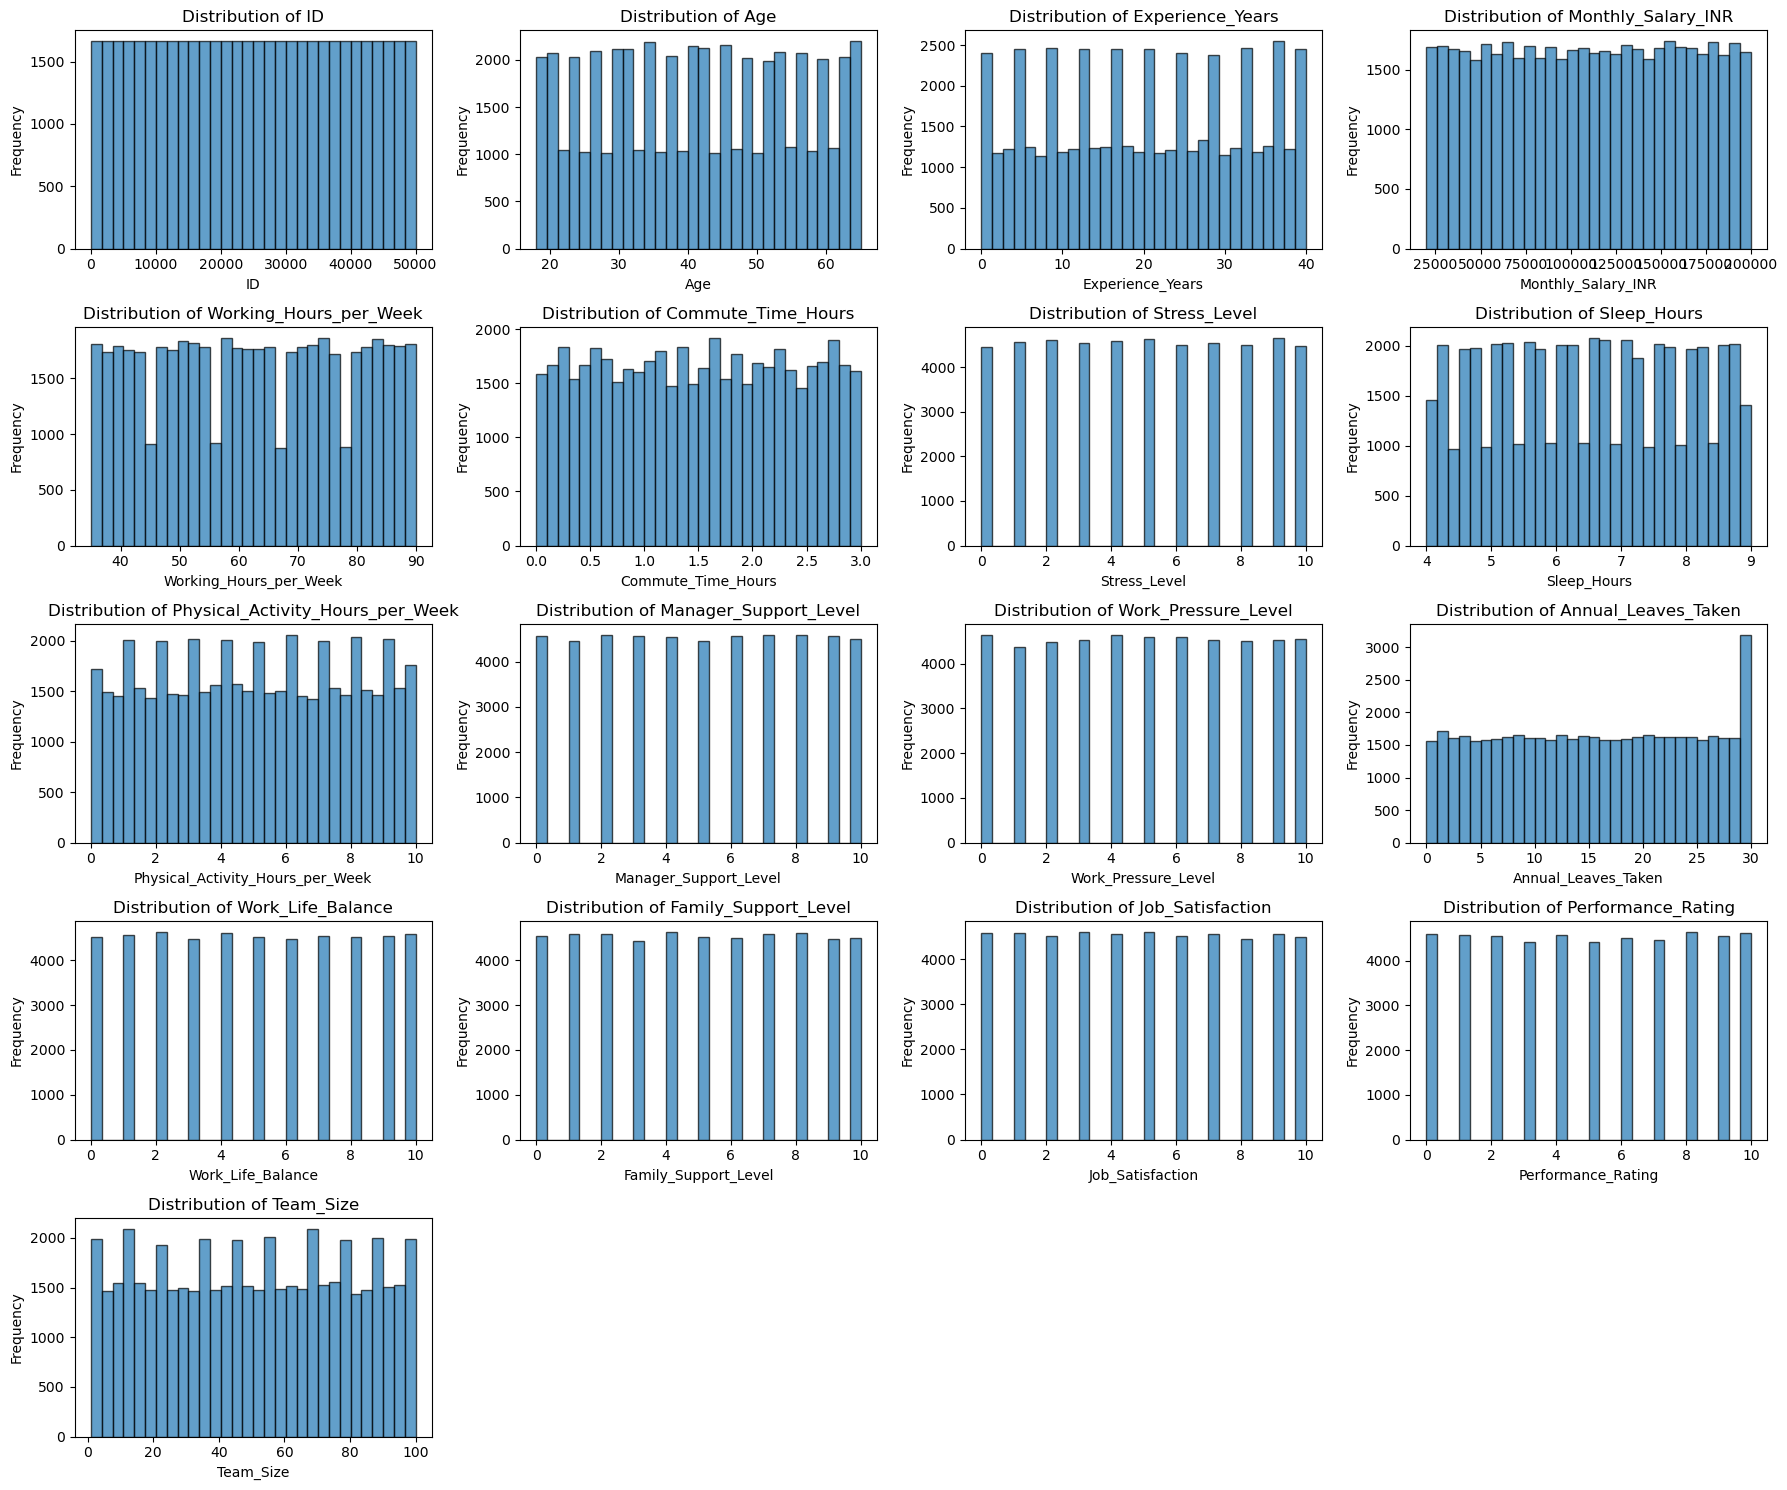

In [76]:
# Set up the figure and axis for the grid
num_columns = len(df.select_dtypes(include=['number']).columns)
num_rows = (num_columns // 4) + (num_columns % 4 > 0)  # Set 3 columns per row, calculate the necessary rows
fig, axes = plt.subplots(num_rows, 4, figsize=(18, num_rows * 3))  # Adjust the figsize as needed

# Flatten the axes array to easily iterate over it
axes = axes.flatten()

# Loop over the numeric columns and plot the histograms
for idx, col in enumerate(df.select_dtypes(include=['number']).columns):
    axes[idx].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

# Remove empty subplots (if any)
for idx in range(num_columns, len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [77]:
df['Burnout_Symptoms'].value_counts()

Burnout_Symptoms
Occasional    16677
No            16662
Yes           16661
Name: count, dtype: int64

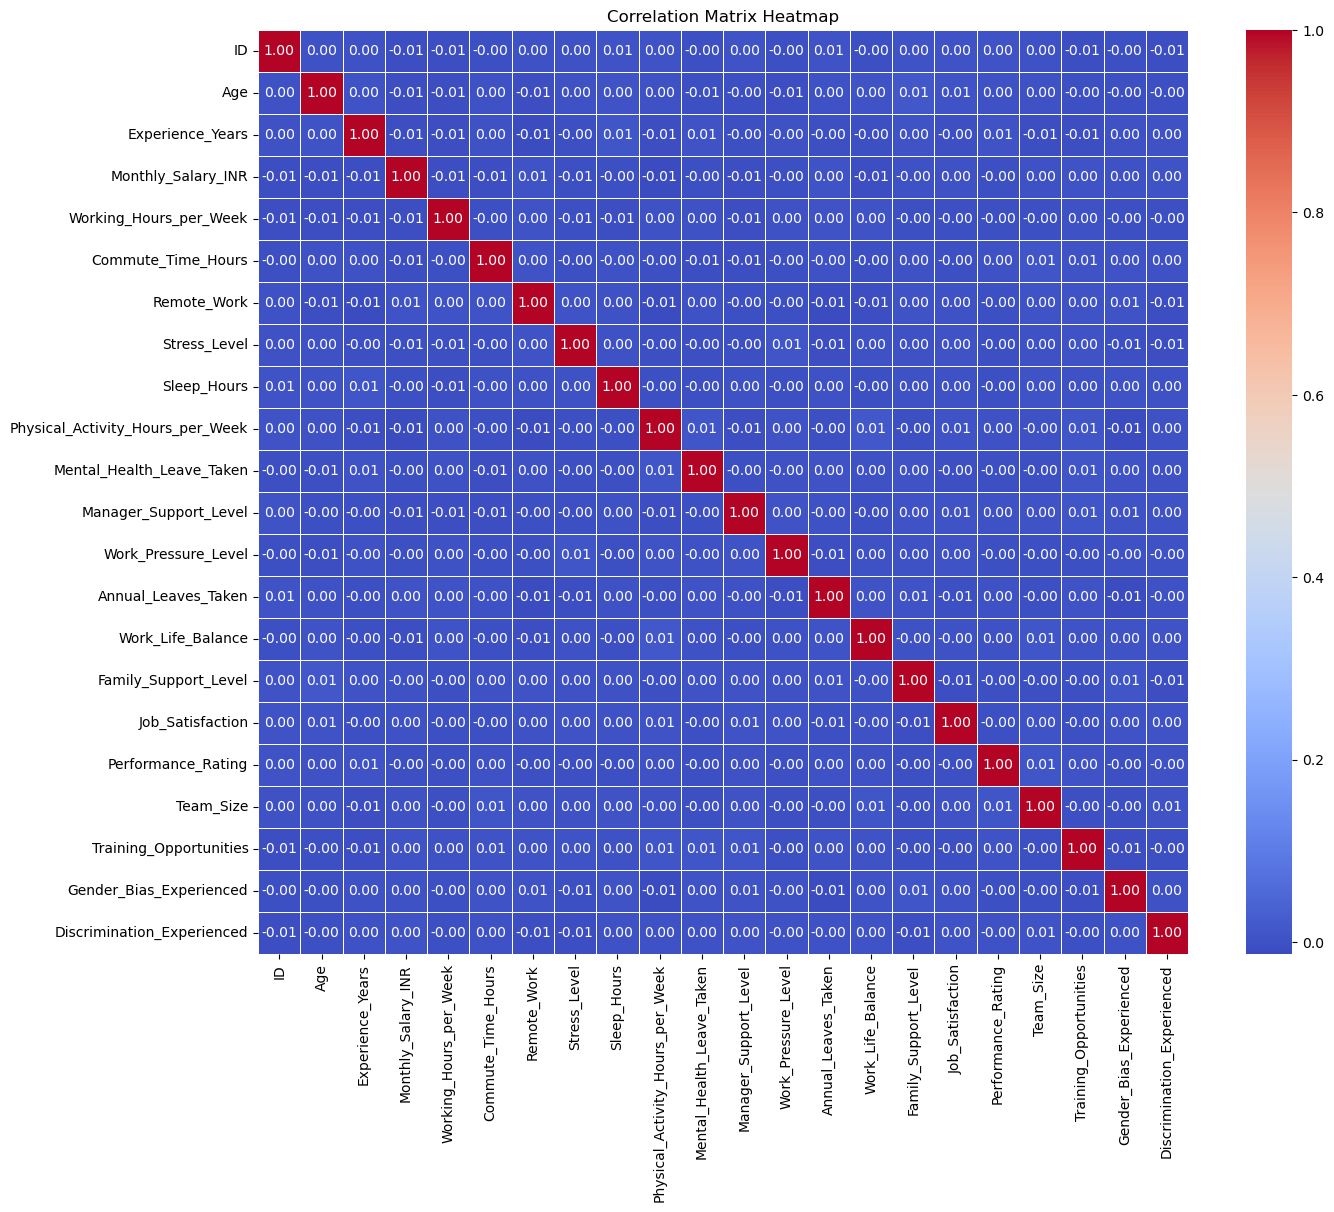

In [78]:
df_encoded = pd.get_dummies(df, drop_first=True)
# Compute Correlation Matrix (Only for Numerical Features)
correlation_matrix = df.corr(method='spearman',numeric_only=True)
# Plot Heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [79]:
missing_percentage = (df.isnull().sum() / len(df)) * 100

# To handle NaN values in the missing percentage (e.g., if a column is entirely NaN)
missing_percentage = missing_percentage.fillna(0)

print("\nPercentage of missing values in each column:")
print(missing_percentage)


Percentage of missing values in each column:
ID                                   0.000
Age                                  0.000
Gender                               0.000
Marital_Status                       0.000
Job_Role                             0.000
Experience_Years                     0.000
Monthly_Salary_INR                   0.000
Working_Hours_per_Week               0.000
Commute_Time_Hours                   0.000
Remote_Work                          0.000
Stress_Level                         0.000
Health_Issues                       25.082
Company_Size                         0.000
Department                           0.000
Sleep_Hours                          0.000
Physical_Activity_Hours_per_Week     0.000
Mental_Health_Leave_Taken            0.000
Manager_Support_Level                0.000
Work_Pressure_Level                  0.000
Annual_Leaves_Taken                  0.000
Work_Life_Balance                    0.000
Family_Support_Level                 0.000
Job_Sati

In [80]:
df['Health_Issues'].value_counts()

Health_Issues
Mental      12534
Both        12518
Physical    12407
Name: count, dtype: int64

In [81]:
import pandas as pd
import numpy as np
import scipy.stats as ss

def cramers_v(x, y):
    """Computes Cramér's V statistic for categorical-categorical correlation."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((k_corr-1), (r_corr-1)))

# Compute correlation
correlation = cramers_v(df["Health_Issues"], df["Burnout_Symptoms"])
print(f"Cramér's V Correlation between Health_Issues and Burnout_Symptoms: {correlation:.3f}")


Cramér's V Correlation between Health_Issues and Burnout_Symptoms: 0.002


### Data Wrangling

Imputation
Variable encoding
attempted knn imputation, with low accuracy indicating there was not a pattern in missingness, so mode impuptation was final decision

In [82]:
# Those that have NA values in health have no health problems
# Encode No in place of NAs
df["Health_Issues"].fillna("No", inplace=True)


In [83]:
missing_percentage = (df.isnull().sum() / len(df)) * 100

# To handle NaN values in the missing percentage (e.g., if a column is entirely NaN)
missing_percentage = missing_percentage.fillna(0)

print("\nPercentage of missing values in each column:")
print(missing_percentage)


Percentage of missing values in each column:
ID                                  0.0
Age                                 0.0
Gender                              0.0
Marital_Status                      0.0
Job_Role                            0.0
Experience_Years                    0.0
Monthly_Salary_INR                  0.0
Working_Hours_per_Week              0.0
Commute_Time_Hours                  0.0
Remote_Work                         0.0
Stress_Level                        0.0
Health_Issues                       0.0
Company_Size                        0.0
Department                          0.0
Sleep_Hours                         0.0
Physical_Activity_Hours_per_Week    0.0
Mental_Health_Leave_Taken           0.0
Manager_Support_Level               0.0
Work_Pressure_Level                 0.0
Annual_Leaves_Taken                 0.0
Work_Life_Balance                   0.0
Family_Support_Level                0.0
Job_Satisfaction                    0.0
Performance_Rating                

In [84]:
# Label encode bc size is ordinal 

#Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode a specific column (e.g., "Category_Column")
df["Company_Size"] = label_encoder.fit_transform(df["Company_Size"])

In [85]:
# For binary encoding include the occasional symptoms to the yes category
# Reducing Dimensionality
df["Burnout_Symptoms"] = df["Burnout_Symptoms"].replace("Occasional", "Yes")

df["Health_Issues"] = df["Health_Issues"].replace("Both", "Yes")
df["Health_Issues"] = df["Health_Issues"].replace("Physical", "Yes")
df["Health_Issues"] = df["Health_Issues"].replace("Mental", "Yes")

In [86]:
# One Hot encode the rest

# Identify categorical columns (excluding numeric ones)
categorical_cols = df.select_dtypes(include=["object"]).columns

df[categorical_cols] = df[categorical_cols].fillna("Unknown")  # Replace NaNs
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ID                                50000 non-null  int64  
 1   Age                               50000 non-null  int64  
 2   Experience_Years                  50000 non-null  int64  
 3   Monthly_Salary_INR                50000 non-null  float64
 4   Working_Hours_per_Week            50000 non-null  int64  
 5   Commute_Time_Hours                50000 non-null  float64
 6   Remote_Work                       50000 non-null  bool   
 7   Stress_Level                      50000 non-null  int64  
 8   Company_Size                      50000 non-null  int32  
 9   Sleep_Hours                       50000 non-null  float64
 10  Physical_Activity_Hours_per_Week  50000 non-null  float64
 11  Mental_Health_Leave_Taken         50000 non-null  bool   
 12  Mana

### Modeling

In [87]:
# Selecting Features and Targets

X = df.drop(columns=["Burnout_Symptoms_Yes"])

y = df["Burnout_Symptoms_Yes"]

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features (important for SVM and Neural Networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Neural Network

#### The Nueral Network optimized with accuracy score, only predicted burnout symptoms. We continued to optimize using f1 score; grid is artificially shrunk from original after initial run so that it is easier for grader to run

In [88]:
# Define hyperparameters to tune
param_grid = {
    'hidden_layer_sizes': [(64,), (128,)],  # Different layer architectures
    'activation': ['relu'],  # Try different activation functions
    'solver': ['adam'],  # Optimizers: Adam vs. SGD
    'alpha': [0.0001],  # Regularization strength
    'learning_rate': ['constant', ]  # Learning rate strategies
}

# Initialize MLP Classifier
mlp = MLPClassifier(max_iter=200, random_state=42)

# Grid Search with Cross-Validation (2-fold)
grid_search = GridSearchCV(mlp, param_grid, cv=2, scoring='f1_weighted', n_jobs=-1, verbose=1)

# Fit the model on training data
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print(f" Best Hyperparameters: {grid_search.best_params_}")
print(f" Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

Fitting 2 folds for each of 2 candidates, totalling 4 fits
 Best Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'learning_rate': 'constant', 'solver': 'adam'}
 Best Cross-Validation Accuracy: 0.5694


C:\Users\roryq\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [89]:
# Get the best model from GridSearch
best_mlp = grid_search.best_estimator_

# Predict on the test set
y_pred_best_mlp = best_mlp.predict(X_test)

# Evaluate performance
from sklearn.metrics import accuracy_score, classification_report

print(" Best Neural Network Performance:")
print(classification_report(y_test, y_pred_best_mlp))

# Final accuracy on test data
final_accuracy = accuracy_score(y_test, y_pred_best_mlp)
print(f" Final Neural Network Accuracy on Test Set: {final_accuracy:.4f}")


 Best Neural Network Performance:
              precision    recall  f1-score   support

       False       0.33      0.22      0.26      3332
        True       0.66      0.77      0.71      6668

    accuracy                           0.59     10000
   macro avg       0.49      0.50      0.49     10000
weighted avg       0.55      0.59      0.56     10000

 Final Neural Network Accuracy on Test Set: 0.5869


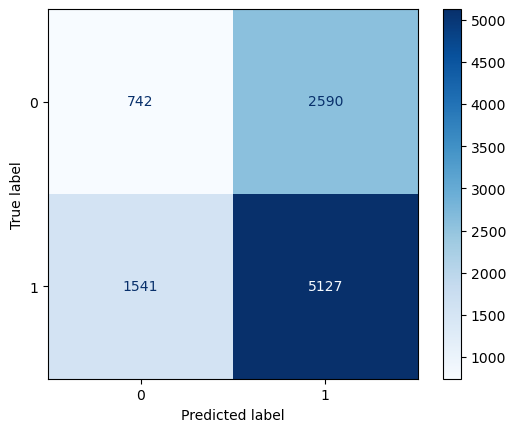

In [90]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_best_mlp)

# Display the confusion matrix in blue
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)  # Use the 'Blues' colormap

# Show the plot
plt.show()

#### Random Forest

In [91]:
# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Define hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [ 100],  # Number of trees in the forest
    'max_depth': [ None],  # Maximum depth of each tree
    'min_samples_split': [2],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1]  # Minimum number of samples required to be at a leaf node
}

# Grid Search with Cross-Validation
rf_grid_search = GridSearchCV(rf, rf_param_grid, scoring='f1_weighted', verbose=1, cv=2)

# Fit the model using GridSearchCV
rf_grid_search.fit(X_train, y_train)

# Get the best Random Forest model
best_rf = rf_grid_search.best_estimator_

# Make predictions on the test set
y_pred_rf = best_rf.predict(X_test)

# Evaluate the Random Forest model
print(" Random Forest Classifier Performance:")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}\n")

# Print best parameters and best score
print(f" Best Hyperparameters: {rf_grid_search.best_params_}")
print(f" Best Cross-Validation Accuracy: {rf_grid_search.best_score_:.4f}")

Fitting 2 folds for each of 1 candidates, totalling 2 fits
 Random Forest Classifier Performance:
              precision    recall  f1-score   support

       False       0.35      0.01      0.01      3332
        True       0.67      0.99      0.80      6668

    accuracy                           0.67     10000
   macro avg       0.51      0.50      0.41     10000
weighted avg       0.56      0.67      0.54     10000

Accuracy: 0.6651

 Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
 Best Cross-Validation Accuracy: 0.5359


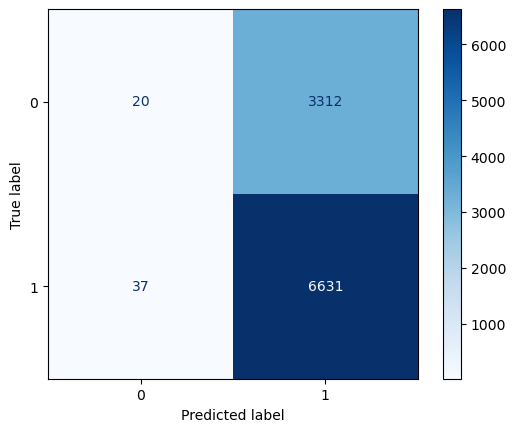

In [92]:
# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot(cmap=plt.cm.Blues)
plt.show()

#### KNN

In [93]:
# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Define hyperparameter grid for KNN
knn_param_grid = {
    'n_neighbors': [3, 5, 10],  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weighting function for prediction
    'metric': ['euclidean']  # Distance metric
}

# Grid Search with Cross-Validation
knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=5, scoring='f1_weighted', verbose=1)

# Fit the model using GridSearchCV
knn_grid_search.fit(X_train, y_train)

# Get the best KNN model
best_knn = knn_grid_search.best_estimator_

# Make predictions on the test set
y_pred_knn = best_knn.predict(X_test)

# Evaluate the KNN model
print(" KNN Classifier Performance:")
print(classification_report(y_test, y_pred_knn))
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}\n")
# Print best parameters and best score
print(f" Best Hyperparameters: {knn_grid_search.best_params_}")
print(f" Best Cross-Validation Accuracy: {knn_grid_search.best_score_:.4f}")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
 KNN Classifier Performance:
              precision    recall  f1-score   support

       False       0.32      0.20      0.25      3332
        True       0.66      0.78      0.72      6668

    accuracy                           0.59     10000
   macro avg       0.49      0.49      0.48     10000
weighted avg       0.55      0.59      0.56     10000

Accuracy: 0.5913

 Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}
 Best Cross-Validation Accuracy: 0.5689


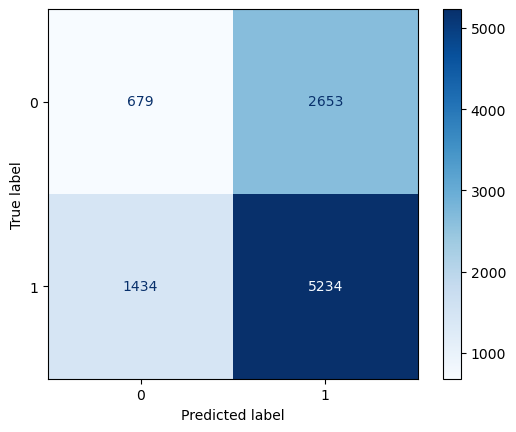

In [94]:
# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp_knn.plot(cmap=plt.cm.Blues)
plt.show()

#### Naive Bayes

In [95]:
# Initialize the Naive Bayes classifier
nb = GaussianNB()

# Since Gaussian Naive Bayes doesn't have many hyperparameters to tune, we usually don't need GridSearchCV
# But, let's show a simple example of tuning the 'var_smoothing' parameter, which helps with numerical stability
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

# Grid Search with Cross-Validation (if you want to fine-tune the var_smoothing parameter)
nb_grid_search = GridSearchCV(nb, param_grid, cv=5, scoring='f1_weighted', verbose=1)

# Fit the model using GridSearchCV
nb_grid_search.fit(X_train, y_train)

# Get the best Naive Bayes model
best_nb = nb_grid_search.best_estimator_

# Make predictions on the test set
y_pred_nb = best_nb.predict(X_test)

# Evaluate the Naive Bayes model
print("  Naive Bayes Classifier Performance:")
print(classification_report(y_test, y_pred_nb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}\n")

# Print best parameters and best score
print(f"  Best Hyperparameters: {nb_grid_search.best_params_}")
print(f"  Best Cross-Validation Accuracy: {nb_grid_search.best_score_:.4f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
  Naive Bayes Classifier Performance:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00      3332
        True       0.67      1.00      0.80      6668

    accuracy                           0.67     10000
   macro avg       0.33      0.50      0.40     10000
weighted avg       0.44      0.67      0.53     10000

Accuracy: 0.6668

  Best Hyperparameters: {'var_smoothing': 1e-09}
  Best Cross-Validation Accuracy: 0.5334


C:\Users\roryq\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\roryq\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\roryq\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


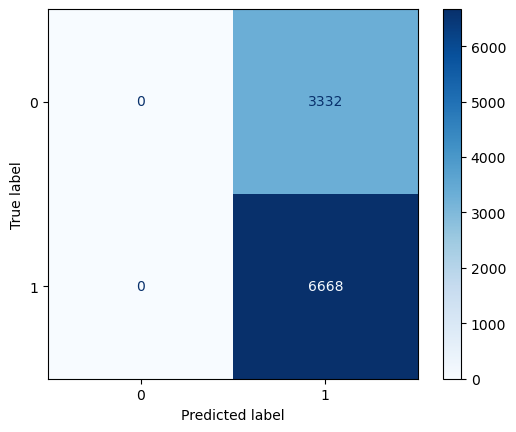

In [96]:
# Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb)
disp_nb.plot(cmap=plt.cm.Blues)
plt.show()

#### XGBoost

In [97]:
# Initialize the XGBoost classifier
xgboost_model = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')

# Define hyperparameter grid for XGBoost
xgboost_param_grid = {
    'n_estimators': [200],  # Number of trees in the model
    'learning_rate': [0.1, 0.2],  # Step size for updating weights
    'max_depth': [3, 7],  # Maximum depth of each tree 
    'colsample_bytree': [0.5, 0.8],  # Fraction of features to use for each tree
    'gamma': [0, 0.2]  # Regularization parameter for pruning
}

# Grid Search with Cross-Validation
xgboost_grid_search = GridSearchCV(xgboost_model, xgboost_param_grid, cv=5, scoring='f1_weighted', verbose=1)

# Fit the model using GridSearchCV
xgboost_grid_search.fit(X_train, y_train)

# Get the best XGBoost model
best_xgboost = xgboost_grid_search.best_estimator_

# Make predictions on the test set
y_pred_xgboost = best_xgboost.predict(X_test)

# Evaluate the XGBoost model
print(" XGBoost Classifier Performance:")
print(classification_report(y_test, y_pred_xgboost))
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgboost):.4f}\n")

# Print best parameters and best score
print(f" Best Hyperparameters: {xgboost_grid_search.best_params_}")
print(f" Best Cross-Validation Accuracy: {xgboost_grid_search.best_score_:.4f}")



Fitting 5 folds for each of 16 candidates, totalling 80 fits
 XGBoost Classifier Performance:
              precision    recall  f1-score   support

       False       0.35      0.09      0.15      3332
        True       0.67      0.91      0.77      6668

    accuracy                           0.64     10000
   macro avg       0.51      0.50      0.46     10000
weighted avg       0.56      0.64      0.56     10000

Accuracy: 0.6396

 Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
 Best Cross-Validation Accuracy: 0.5609


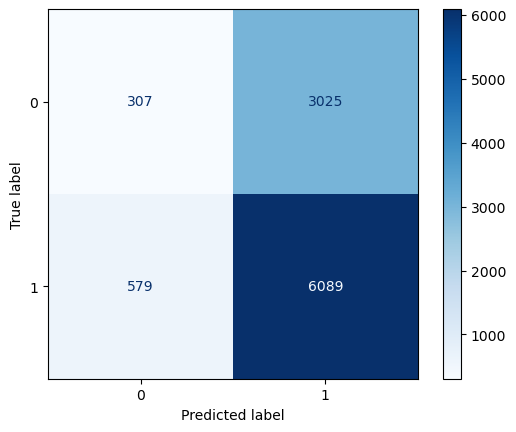

In [98]:
# Confusion Matrix
cm_xgboost = confusion_matrix(y_test, y_pred_xgboost)
disp_xgboost = ConfusionMatrixDisplay(confusion_matrix=cm_xgboost)
disp_xgboost.plot(cmap=plt.cm.Blues)
plt.show()

#### SVM

In [99]:
# Initialize and train the SVM classifier without GridSearchCV
best_svm = SVC(C=0.1, kernel='linear', gamma='scale', random_state=42)

# Fit the model on training data
best_svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = best_svm.predict(X_test)

# Evaluate the SVM model
print("SVM Classifier Performance:")
print(classification_report(y_test, y_pred_svm))
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")

SVM Classifier Performance:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00      3332
        True       0.67      1.00      0.80      6668

    accuracy                           0.67     10000
   macro avg       0.33      0.50      0.40     10000
weighted avg       0.44      0.67      0.53     10000

Accuracy: 0.6668


C:\Users\roryq\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\roryq\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\roryq\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model Comparisons

In [100]:


# Dictionary to store computation times
computation_times = {}



# List of models and their names
models = {
    
 
    "KNN": best_knn,
    "MLP": best_mlp,
    "XGBoost": best_xgboost,
    "Random Forest": best_rf,
    "Naive Bayes": best_nb,
    "SVM": best_svm
}

# Perform 5-fold cross-validation and collect scores
cv_results = {}
for name, model in models.items():
    start_time = time.time()
    
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)
    cv_results[name] = scores
   
    end_time = time.time()  # End timing
    
    computation_times[name] = end_time - start_time  # Store elapsed time



In [101]:
cv_results


{'KNN': array([0.57055668, 0.56735141, 0.56831095, 0.57251163, 0.56577669]),
 'MLP': array([0.56465959, 0.562839  , 0.56856001, 0.56151823, 0.56982618]),
 'XGBoost': array([0.56032805, 0.56218851, 0.55708323, 0.56120572, 0.56349197]),
 'Random Forest': array([0.535213  , 0.53598539, 0.53566157, 0.53394632, 0.53523262]),
 'Naive Bayes': array([0.53344, 0.53344, 0.53344, 0.53344, 0.53344]),
 'SVM': array([0.53344, 0.53344, 0.53344, 0.53344, 0.53344])}

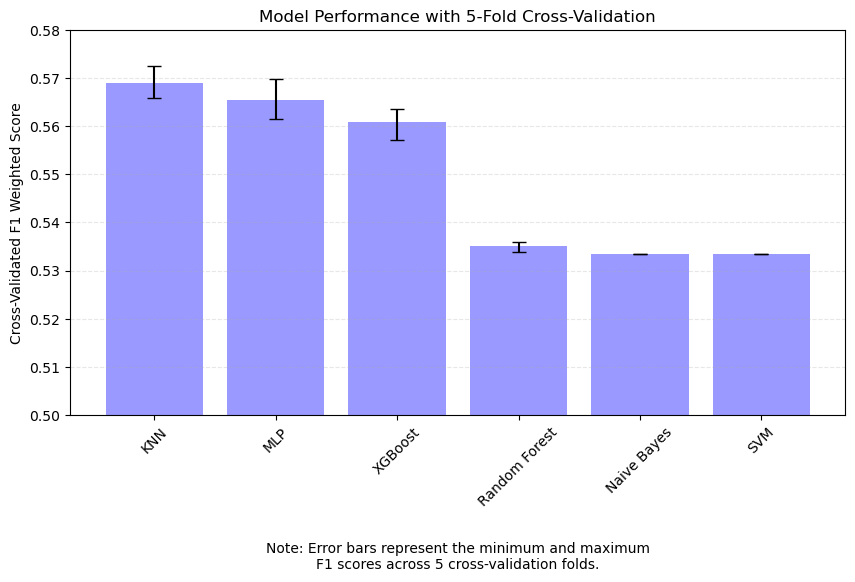

In [102]:
# Extract averages, min, and max values
model_names = list(cv_results.keys())
avg_scores = [np.mean(scores) for scores in cv_results.values()]
min_scores = [np.min(scores) for scores in cv_results.values()]
max_scores = [np.max(scores) for scores in cv_results.values()]

# Compute overlapping error regions (min-max ranges)
overall_min = np.max(min_scores)  # Max of the minimums
overall_max = np.min(max_scores)  # Min of the maximums


# Plot the results
plt.figure(figsize=(10, 5))
plt.bar(model_names, avg_scores, yerr=[np.array(avg_scores) - np.array(min_scores), np.array(max_scores) - np.array(avg_scores)], capsize=5, color='blue', alpha=0.4)

# Highlight overlap region with a red band
if overall_min < overall_max:
    plt.axhspan(overall_min, overall_max, color='red', alpha=0.3, label="Overlapping Error Range")
plt.ylabel("Cross-Validated F1 Weighted Score")
plt.title("Model Performance with 5-Fold Cross-Validation")
plt.ylim(0.5, 0.58)  # Accuracy ranges from 0 to 1
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.annotate("Note: Error bars represent the minimum and maximum\n"
             "F1 scores across 5 cross-validation folds.",
             xy=(0.5, -0.4), xycoords='axes fraction', 
             ha='center', fontsize=10, color="black")

plt.show()

Initially it appeared simple classifiers had a low accuracy so we continued to fit more complex models, however after comparing model preformance we can see that that initial simple classifiers were the best overall

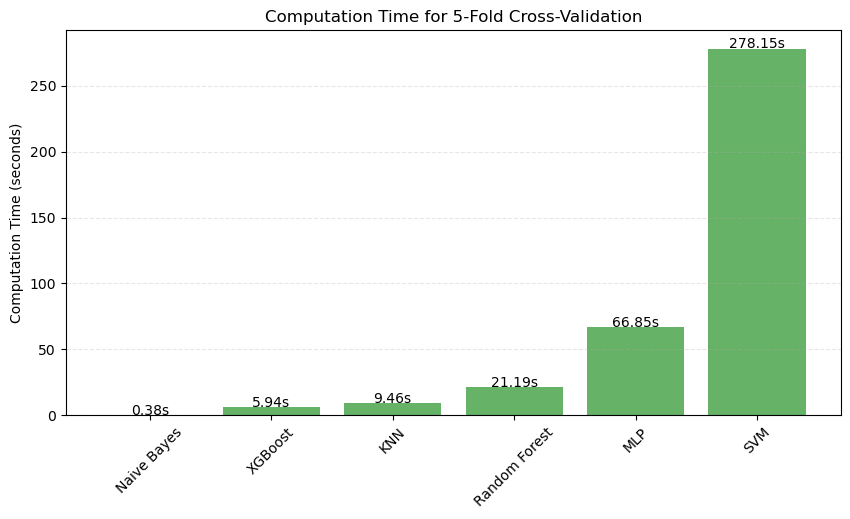

In [103]:
# Extract model names and their computation times
model_names = list(computation_times.keys())
comp_times = list(computation_times.values())


# Sort models by computation time (ascending order)
sorted_indices = np.argsort(comp_times)
sorted_model_names = np.array(model_names)[sorted_indices]
sorted_comp_times = np.array(comp_times)[sorted_indices]

# Plot Computation Time Comparison (Ordered by Time)
plt.figure(figsize=(10, 5))
plt.bar(sorted_model_names, sorted_comp_times, color='green', alpha=0.6)
plt.ylabel("Computation Time (seconds)")
plt.title("Computation Time for 5-Fold Cross-Validation")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Annotate the bars with exact time values
for i, v in enumerate(sorted_comp_times):
    plt.text(i, v + 0.2, f"{v:.2f}s", ha='center', fontsize=10, color='black')

plt.show()

#### Features and Gender

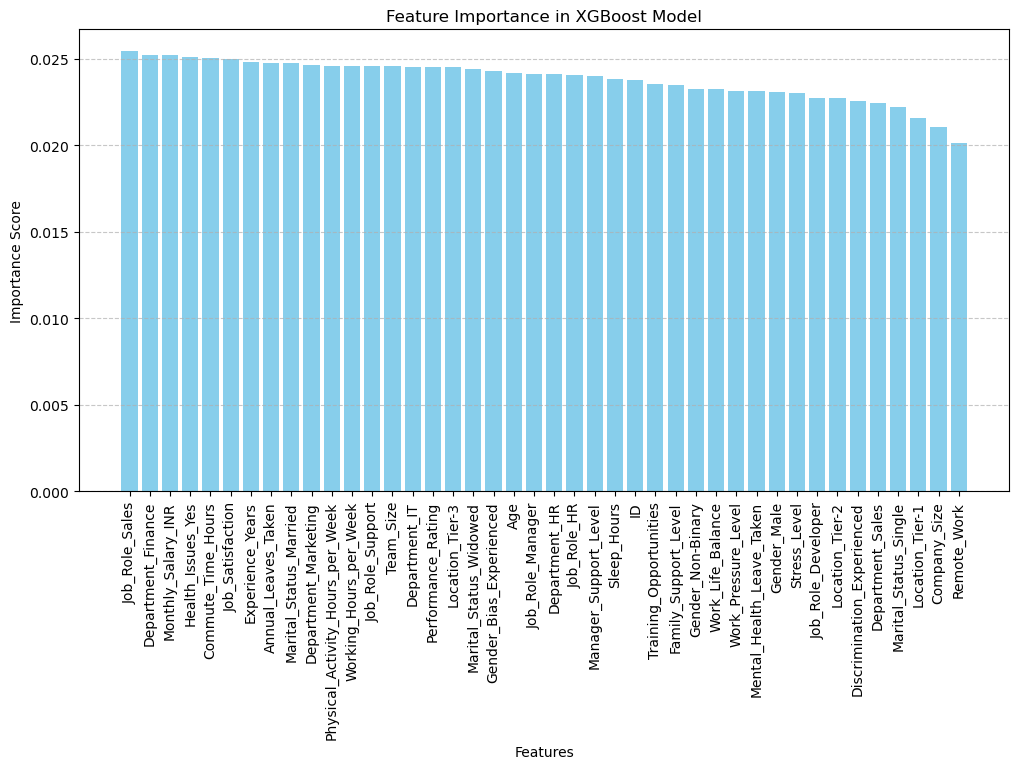

<Figure size 640x480 with 0 Axes>

In [104]:
# Get feature importances from XGBoost
feature_importances = best_xgboost.feature_importances_
feature_names = X.columns

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = np.array(feature_names)[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align="center", color='skyblue')
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Feature Importance in XGBoost Model")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.savefig("feature_importance_XG.png", dpi=300, bbox_inches="tight")  # Save as PNG


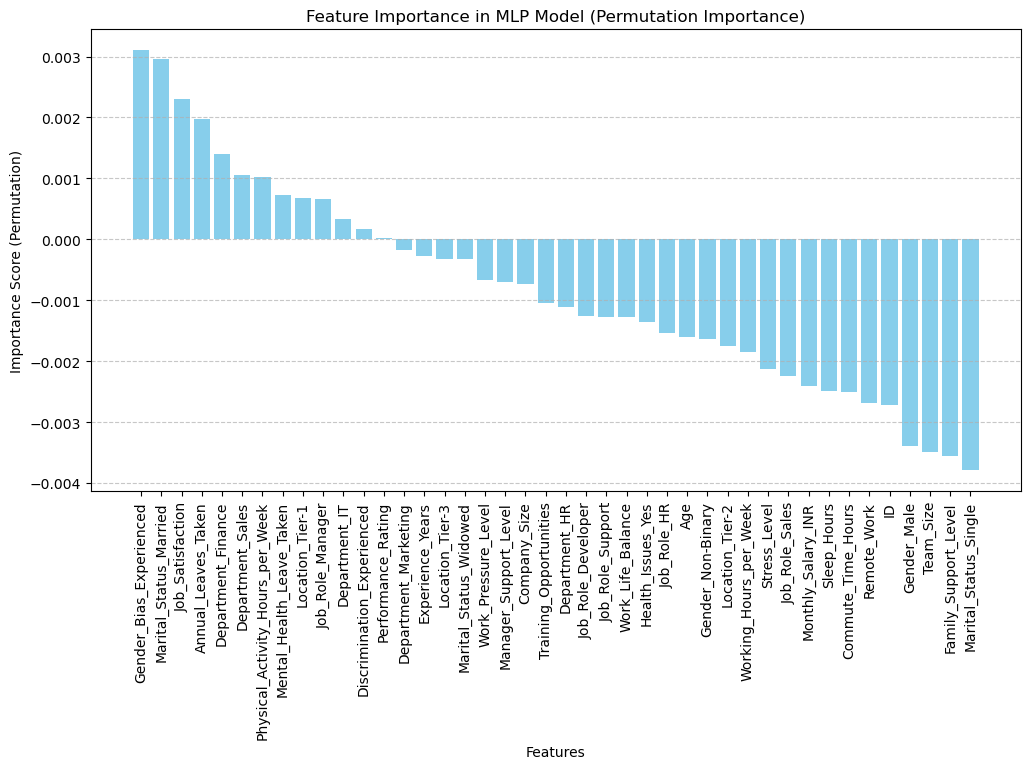

In [105]:
# Compute permutation importance
result = permutation_importance(best_mlp, X_test, y_test, scoring='f1_weighted', n_repeats=2, random_state=42)

# Extract feature importance scores
feature_importances = result.importances_mean
feature_names = X.columns

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = np.array(feature_names)[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align="center", color='skyblue')
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Score (Permutation)")
plt.title("Feature Importance in MLP Model (Permutation Importance)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

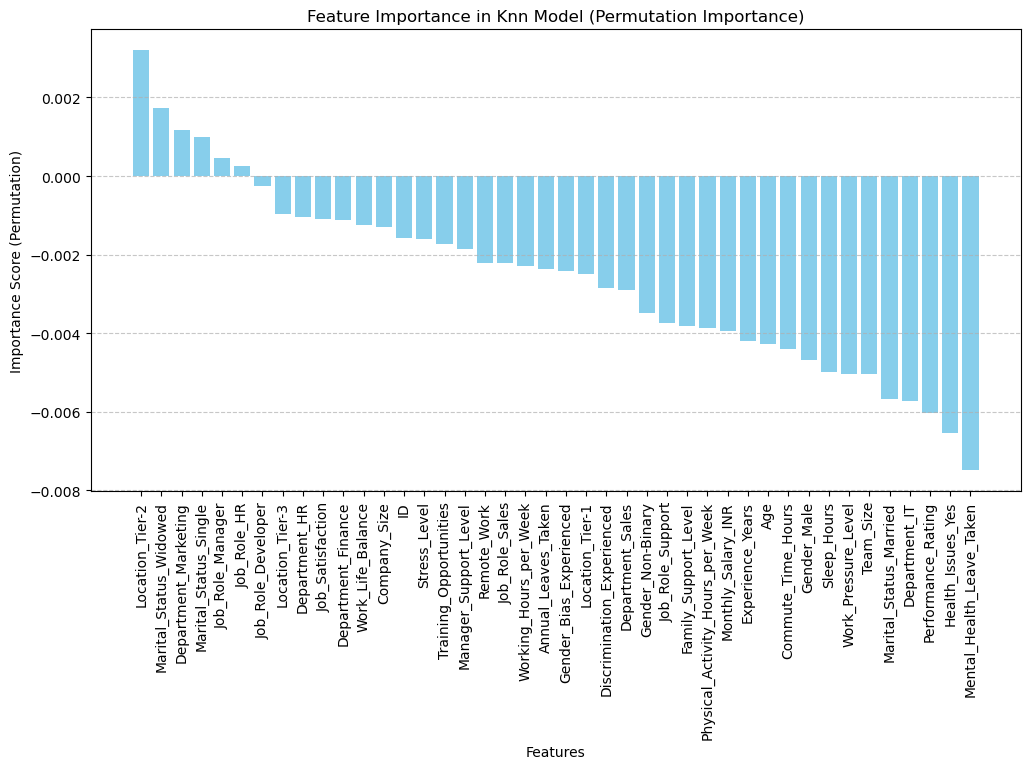

In [106]:
# Compute permutation importance
result = permutation_importance(best_knn, X_test, y_test, scoring='f1_weighted', n_repeats=5, random_state=42)

# Extract feature importance scores
feature_importances = result.importances_mean
feature_names = X.columns

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = np.array(feature_names)[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align="center", color='skyblue')
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Score (Permutation)")
plt.title("Feature Importance in Knn Model (Permutation Importance)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

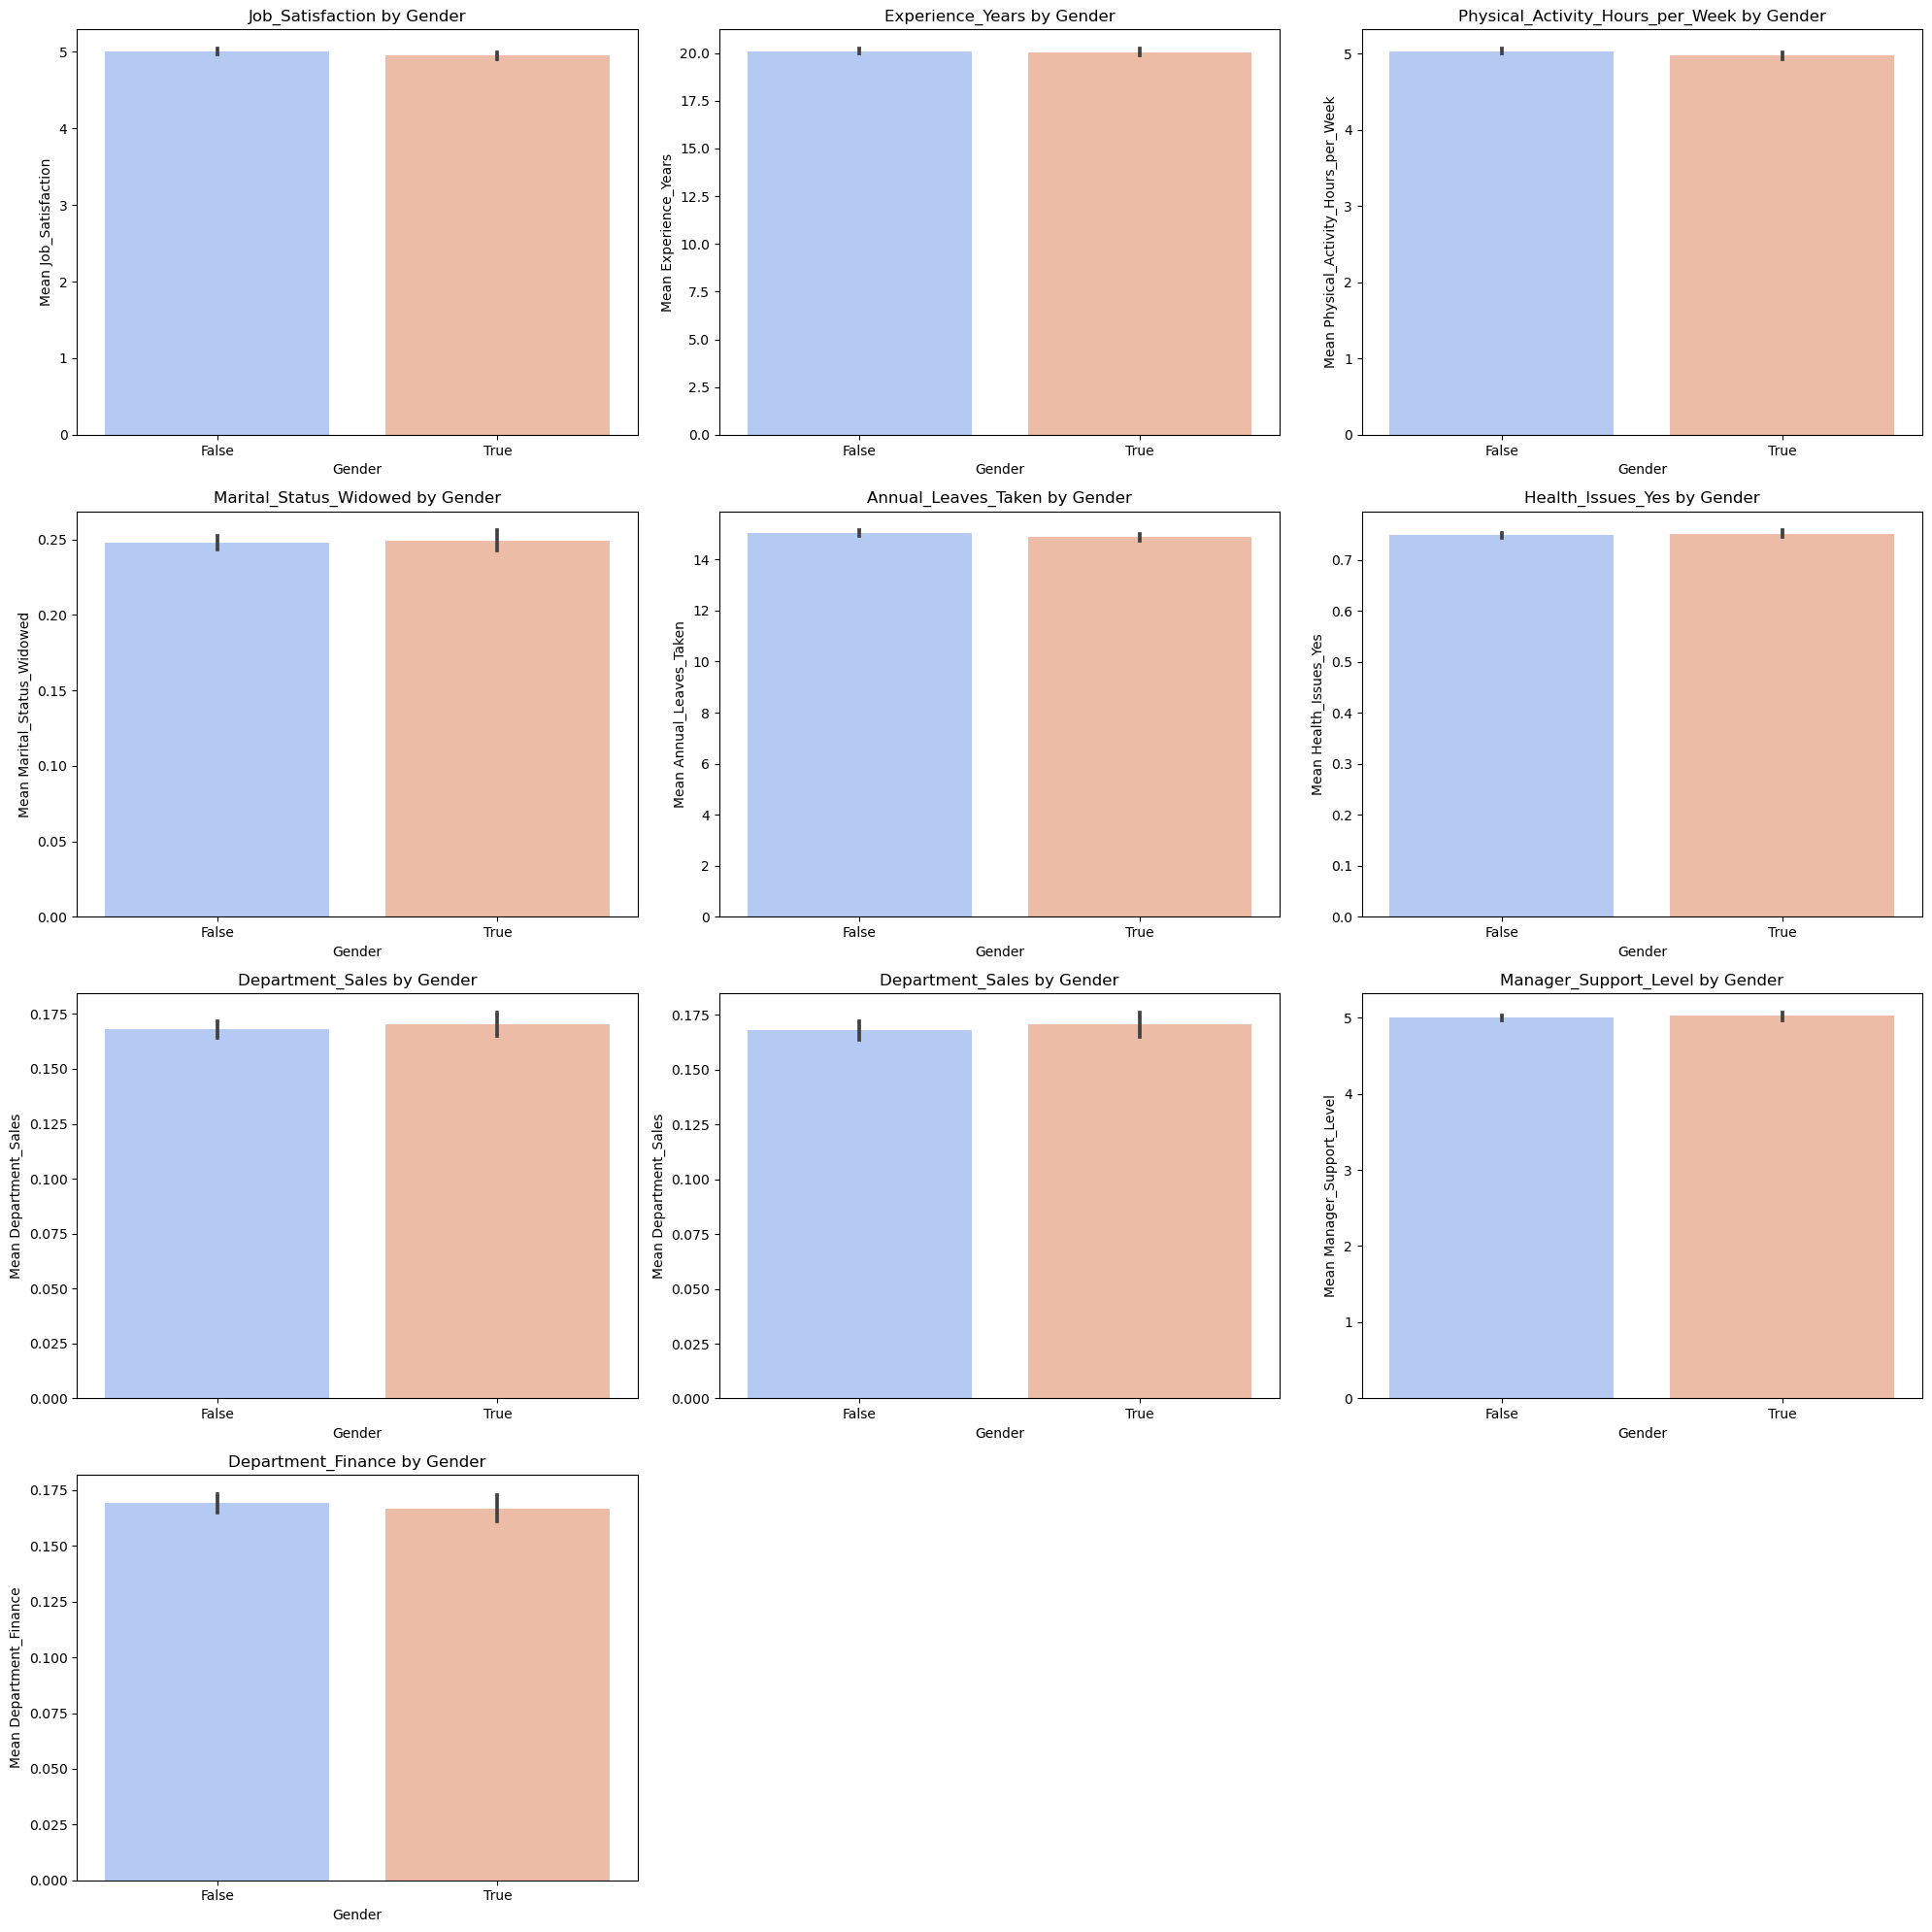

In [107]:
# Define the specific features you want to plot
top_features = ["Job_Satisfaction", "Experience_Years", "Physical_Activity_Hours_per_Week", 
                     "Marital_Status_Widowed", "Annual_Leaves_Taken", "Health_Issues_Yes", 
                     "Department_Sales", "Department_Sales", "Manager_Support_Level", "Department_Finance"]


# Replace boolean values in "Gender_Male" with "Female" and "Male"
df["Gender_Label"] = df["Gender_Male"].replace({0: "Female", 1: "Male"})

# Convert categorical variables back for grouping
df_grouped = df.groupby(["Gender_Label"])[top_features].mean().reset_index()

# Create a grid layout for subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 20))  # 4 rows, 3 columns for 10 features
axes = axes.flatten()

# Plot differences in top features across Gender
for i, feature in enumerate(top_features):
    sns.barplot(data=df, x="Gender_Label", y=feature, palette="coolwarm", ax=axes[i])
    axes[i].set_title(f"{feature} by Gender")
    axes[i].set_xlabel("Gender")
    axes[i].set_ylabel(f"Mean {feature}")

# Remove empty subplots if less than grid size
for i in range(len(top_features), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout for readability
plt.tight_layout()
plt.show()


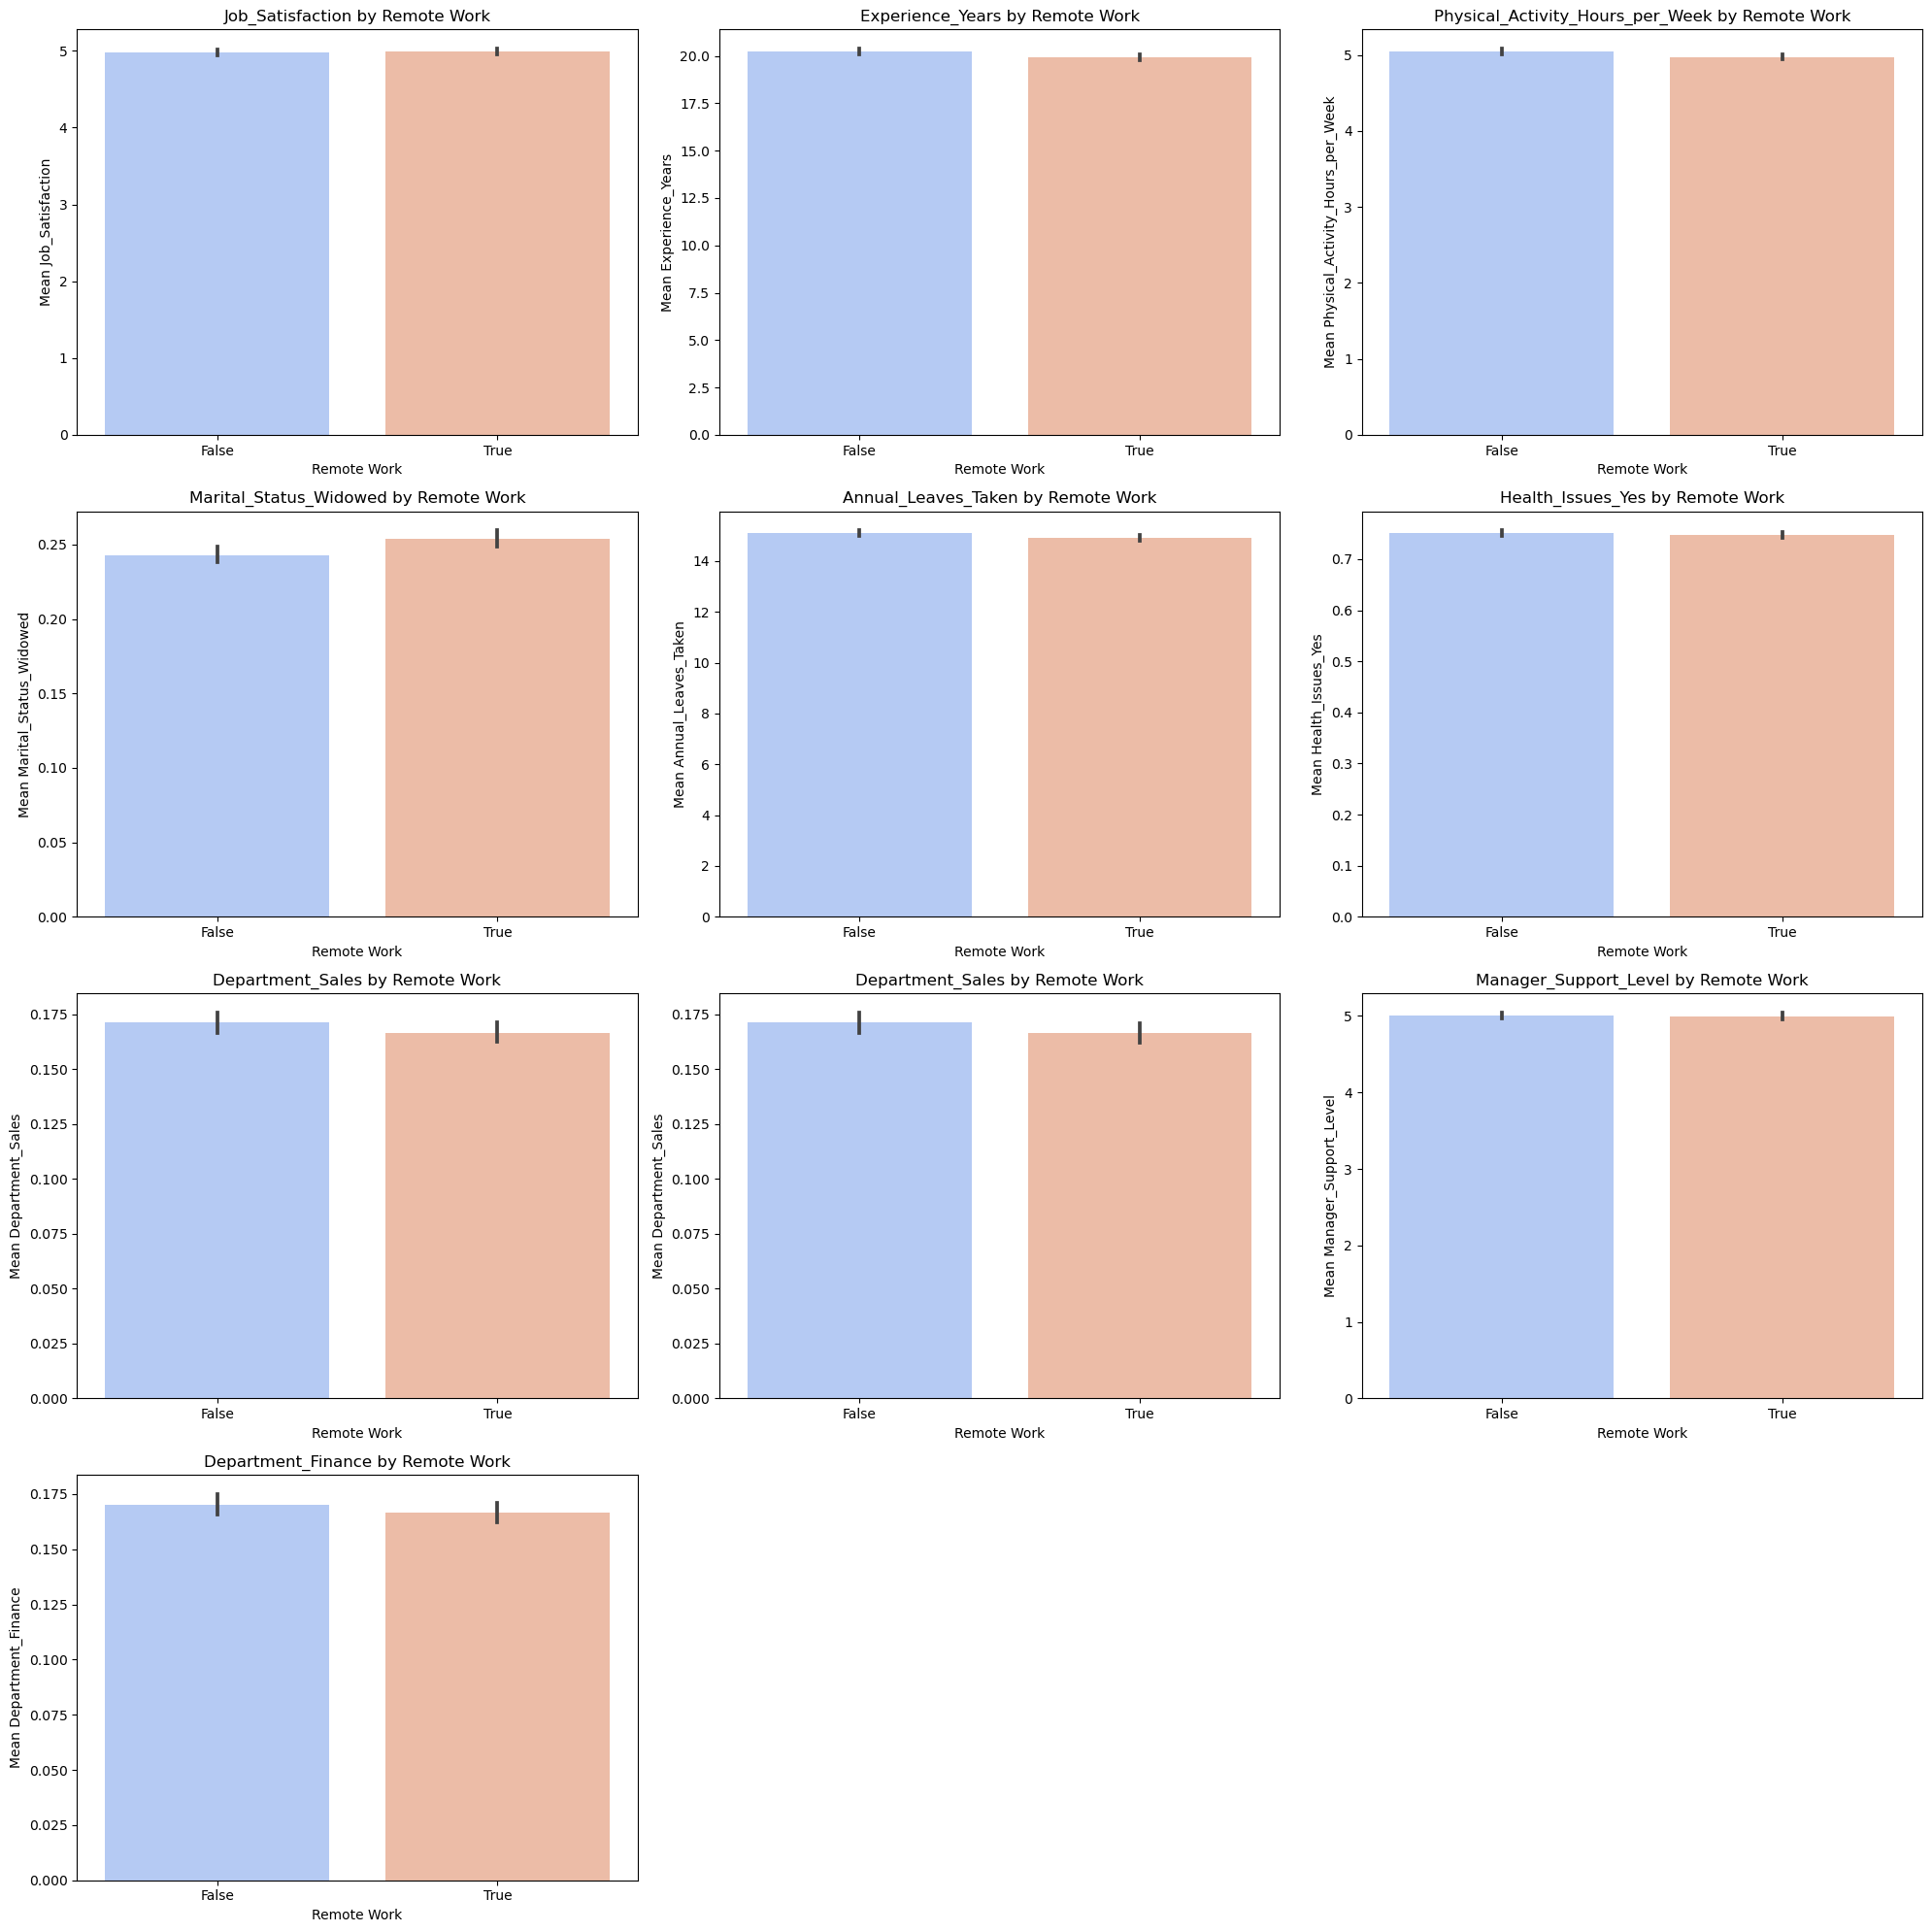

In [108]:


# Convert categorical variables back for grouping
df_grouped = df.groupby(["Remote_Work"])[top_features].mean().reset_index()

# Create a grid layout for subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 20))  # 2 rows, 3 columns
axes = axes.flatten()

# Plot differences in top features across Gender & Remote Work
for i, feature in enumerate(top_features):
    sns.barplot(data=df, x="Remote_Work", y=feature,  palette="coolwarm", ax=axes[i])
    axes[i].set_title(f"{feature} by Remote Work")
    axes[i].set_xlabel("Remote Work")
    axes[i].set_ylabel(f"Mean {feature}")
    
# Remove empty subplot (if number of features is less than grid size)
for i in range(len(top_features), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()

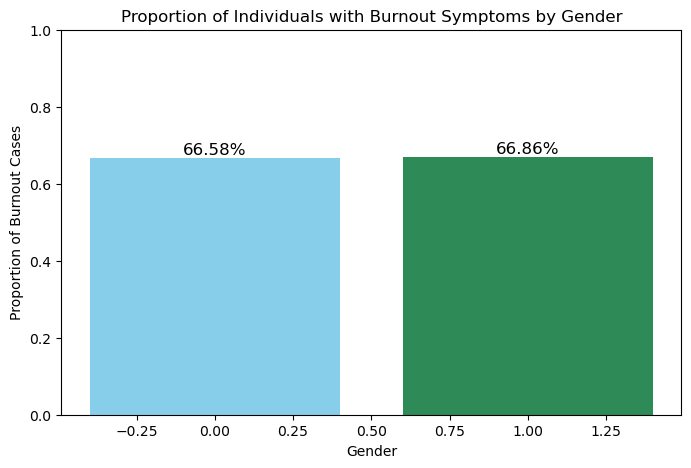

In [109]:
import matplotlib.pyplot as plt

# Count total men and women in the dataset
gender_counts = df["Gender_Male"].value_counts()

# Count the number of burnout cases by gender
burnout_counts = df.groupby("Gender_Male")["Burnout_Symptoms_Yes"].sum()

# Compute proportion of burnout cases per gender
burnout_proportions = burnout_counts / gender_counts

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(burnout_proportions.index, burnout_proportions.values, color=["skyblue", "seagreen"])
plt.xlabel("Gender")
plt.ylabel("Proportion of Burnout Cases")
plt.title("Proportion of Individuals with Burnout Symptoms by Gender")
plt.ylim(0,1)
# Show values on bars
for i, v in enumerate(burnout_proportions.values):
    plt.text(i, v + 0.01, f"{v:.2%}", ha='center', fontsize=12)

plt.show()


### Reduction in Top Predictors

In [110]:
# Ensure feature names are retrieved BEFORE preprocessing (replace df with your original dataset)
original_feature_names = df.drop(columns=["Burnout_Symptoms_Yes"]).columns.tolist()

# Convert X_test back to a DataFrame with original column names
X_test = pd.DataFrame(X_test, columns=original_feature_names[:X_test.shape[1]])

# Check that feature names were restored
print("Updated Feature Names in X_test:\n", X_test.columns.tolist())

# Create a copy for policy simulation
X_test_policy = X_test.copy()
X_test_policy

Updated Feature Names in X_test:
 ['ID', 'Age', 'Experience_Years', 'Monthly_Salary_INR', 'Working_Hours_per_Week', 'Commute_Time_Hours', 'Remote_Work', 'Stress_Level', 'Company_Size', 'Sleep_Hours', 'Physical_Activity_Hours_per_Week', 'Mental_Health_Leave_Taken', 'Manager_Support_Level', 'Work_Pressure_Level', 'Annual_Leaves_Taken', 'Work_Life_Balance', 'Family_Support_Level', 'Job_Satisfaction', 'Performance_Rating', 'Team_Size', 'Training_Opportunities', 'Gender_Bias_Experienced', 'Discrimination_Experienced', 'Gender_Male', 'Gender_Non-Binary', 'Marital_Status_Married', 'Marital_Status_Single', 'Marital_Status_Widowed', 'Job_Role_Developer', 'Job_Role_HR', 'Job_Role_Manager', 'Job_Role_Sales', 'Job_Role_Support', 'Health_Issues_Yes', 'Department_Finance', 'Department_HR', 'Department_IT', 'Department_Marketing', 'Department_Sales', 'Location_Tier-1', 'Location_Tier-2', 'Location_Tier-3']


,ID,Age,Experience_Years,Monthly_Salary_INR,Working_Hours_per_Week,Commute_Time_Hours,Remote_Work,Stress_Level,Company_Size,Sleep_Hours,...,Job_Role_Support,Health_Issues_Yes,Department_Finance,Department_HR,Department_IT,Department_Marketing,Department_Sales,Location_Tier-1,Location_Tier-2,Location_Tier-3
0,-1.439469,-1.551475,0.667788,0.562757,-1.209976,0.658761,0.992528,-1.587880,-0.009986,-1.113379,...,-0.441903,-1.730782,-0.451687,-0.442631,2.243476,-0.445052,-0.451447,1.735638,-0.579082,-0.575041
1,1.523658,1.408687,0.667788,-1.388499,-0.406960,-0.711855,0.992528,-0.953698,-0.009986,-1.252656,...,-0.441903,0.577774,2.213921,-0.442631,-0.445737,-0.445052,-0.451447,-0.576157,1.726870,-0.575041
2,0.101603,1.408687,-1.359466,1.064573,1.507922,-0.677301,-1.007528,-0.953698,1.215340,-0.208080,...,-0.441903,0.577774,2.213921,-0.442631,-0.445737,-0.445052,-0.451447,1.735638,-0.579082,-0.575041
3,-0.260145,-0.901683,1.259070,1.283846,0.766677,-1.667830,-1.007528,1.265937,1.215340,-0.625910,...,-0.441903,0.577774,-0.451687,2.259220,-0.445737,-0.445052,-0.451447,-0.576157,-0.579082,-0.575041
4,0.260131,-1.190480,0.921195,-0.139309,1.446152,-1.207119,-1.007528,-1.270789,1.215340,0.627582,...,-0.441903,0.577774,-0.451687,-0.442631,-0.445737,-0.445052,-0.451447,-0.576157,-0.579082,1.739007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-1.136228,-1.623674,-1.190528,-0.974746,-0.715812,-1.483546,0.992528,-0.002426,1.215340,-1.531210,...,-0.441903,0.577774,-0.451687,-0.442631,-0.445737,2.246929,-0.451447,1.735638,-0.579082,-0.575041
9996,-1.175739,1.480886,-1.612873,-0.681396,0.025432,0.739385,-1.007528,0.314665,-1.235313,-0.974102,...,-0.441903,0.577774,-0.451687,-0.442631,2.243476,-0.445052,-0.451447,1.735638,-0.579082,-0.575041
9997,0.526416,-0.324091,1.681415,-0.647941,-1.518828,-0.642748,-1.007528,-1.587880,1.215340,-0.416995,...,-0.441903,-1.730782,-0.451687,2.259220,-0.445737,-0.445052,-0.451447,-0.576157,-0.579082,1.739007
9998,1.071698,0.325701,-1.443935,-1.675305,-0.839353,-0.723372,-1.007528,-0.953698,1.215340,-0.556272,...,-0.441903,-1.730782,-0.451687,-0.442631,-0.445737,2.246929,-0.451447,-0.576157,1.726870,-0.575041


In [111]:
# Ensure predictors exist in dataset
top_predictors = ["Commute_Time_Hours", "Experience_Years"]  # Replace with actual feature names

# Apply a 20% reduction for non-binary features
for feature in top_predictors:
    if feature in X_test_policy.columns:
        # Reduce all values by 20% proportionally
        X_test_policy[feature] *= 0.8
        print(f"✅ Reduced {feature} by 20%")

# Print before and after average values
for feature in top_predictors:
    before = X_test[feature].mean()
    after = X_test_policy[feature].mean()
    print(f"{feature} - Before: {before:.4f}, After: {after:.4f}")


✅ Reduced Commute_Time_Hours by 20%
✅ Reduced Experience_Years by 20%
Commute_Time_Hours - Before: 0.0139, After: 0.0111
Experience_Years - Before: -0.0096, After: -0.0077


C:\Users\roryq\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\roryq\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Original Model Performance:
              precision    recall  f1-score   support

       False       0.32      0.20      0.25      3332
        True       0.66      0.78      0.72      6668

    accuracy                           0.59     10000
   macro avg       0.49      0.49      0.48     10000
weighted avg       0.55      0.59      0.56     10000

Original Predicted Burnout Rate: 0.7887

Policy-Adjusted Model Performance:
              precision    recall  f1-score   support

       False       0.33      0.21      0.26      3332
        True       0.67      0.79      0.72      6668

    accuracy                           0.59     10000
   macro avg       0.50      0.50      0.49     10000
weighted avg       0.55      0.59      0.57     10000

Predicted Burnout Rate After Policy: 0.7864

Estimated Reduction in Burnout: 0.29%


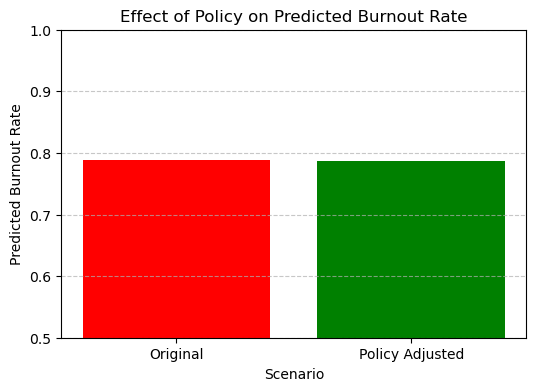

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


# Predict burnout before and after policy
y_pred_original = best_knn.predict(X_test)
y_pred_policy = best_knn.predict(X_test_policy)

# Evaluate effectiveness
original_burnout_rate = np.mean(y_pred_original)
policy_burnout_rate = np.mean(y_pred_policy)
reduction_percentage = (original_burnout_rate - policy_burnout_rate) / original_burnout_rate * 100 if original_burnout_rate > 0 else 0

# Print evaluation results
print("Original Model Performance:")
print(classification_report(y_test, y_pred_original))
print(f"Original Predicted Burnout Rate: {original_burnout_rate:.4f}\n")

print("Policy-Adjusted Model Performance:")
print(classification_report(y_test, y_pred_policy))
print(f"Predicted Burnout Rate After Policy: {policy_burnout_rate:.4f}\n")

print(f"Estimated Reduction in Burnout: {reduction_percentage:.2f}%")

# Visualize burnout rate before and after policy
plt.figure(figsize=(6, 4))
plt.bar(["Original", "Policy Adjusted"], [original_burnout_rate, policy_burnout_rate], color=["red", "green"])
plt.xlabel("Scenario")
plt.ylabel("Predicted Burnout Rate")
plt.title("Effect of Policy on Predicted Burnout Rate")
plt.ylim(0.5, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


In [113]:
# Check available columns
print(X_test.columns.tolist())

# Check if the column exists
if top_predictors[0] not in X_test.columns:
    print(f"Column {top_predictors[0]} not found in X_test!")
if top_predictors[1] not in X_test.columns:
    print(f"Column {top_predictors[1]} not found in X_test!")


['ID', 'Age', 'Experience_Years', 'Monthly_Salary_INR', 'Working_Hours_per_Week', 'Commute_Time_Hours', 'Remote_Work', 'Stress_Level', 'Company_Size', 'Sleep_Hours', 'Physical_Activity_Hours_per_Week', 'Mental_Health_Leave_Taken', 'Manager_Support_Level', 'Work_Pressure_Level', 'Annual_Leaves_Taken', 'Work_Life_Balance', 'Family_Support_Level', 'Job_Satisfaction', 'Performance_Rating', 'Team_Size', 'Training_Opportunities', 'Gender_Bias_Experienced', 'Discrimination_Experienced', 'Gender_Male', 'Gender_Non-Binary', 'Marital_Status_Married', 'Marital_Status_Single', 'Marital_Status_Widowed', 'Job_Role_Developer', 'Job_Role_HR', 'Job_Role_Manager', 'Job_Role_Sales', 'Job_Role_Support', 'Health_Issues_Yes', 'Department_Finance', 'Department_HR', 'Department_IT', 'Department_Marketing', 'Department_Sales', 'Location_Tier-1', 'Location_Tier-2', 'Location_Tier-3']


In [114]:
print(f"Original {top_predictors[0]} count: {X_test[top_predictors[0]].sum()}")
print(f"Modified {top_predictors[0]} count: {X_test_policy[top_predictors[0]].sum()}")

print(f"Original {top_predictors[1]} count: {X_test[top_predictors[1]].sum()}")
print(f"Modified {top_predictors[1]} count: {X_test_policy[top_predictors[1]].sum()}")


Original Commute_Time_Hours count: 138.51855261343152
Modified Commute_Time_Hours count: 110.81484209074522
Original Experience_Years count: -95.85109427972205
Modified Experience_Years count: -76.68087542377756


In [115]:
print("Checking differences in features after policy change...")
print(X_test[top_predictors].describe())
print(X_test_policy[top_predictors].describe())

print("\nChecking prediction distributions:")
print("Original:", np.bincount(y_pred_original))
print("Policy:", np.bincount(y_pred_policy))


Checking differences in features after policy change...
       Commute_Time_Hours  Experience_Years
count        10000.000000      10000.000000
mean             0.013852         -0.009585
std              0.997128          0.998698
min             -1.725419         -1.697341
25%             -0.850068         -0.852652
50%              0.025283         -0.007963
75%              0.877599          0.836726
max              1.729914          1.681415
       Commute_Time_Hours  Experience_Years
count        10000.000000      10000.000000
mean             0.011081         -0.007668
std              0.797703          0.798958
min             -1.380335         -1.357873
25%             -0.680054         -0.682122
50%              0.020227         -0.006371
75%              0.702079          0.669381
max              1.383931          1.345132

Checking prediction distributions:
Original: [2113 7887]
Policy: [2136 7864]


C:\Users\roryq\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\roryq\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


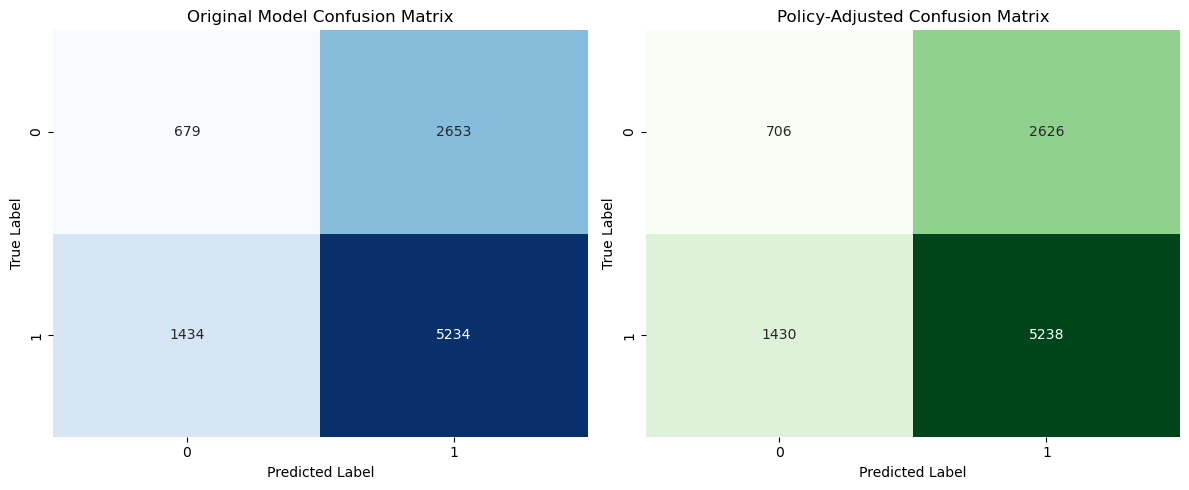

Original Model Performance:
              precision    recall  f1-score   support

       False       0.32      0.20      0.25      3332
        True       0.66      0.78      0.72      6668

    accuracy                           0.59     10000
   macro avg       0.49      0.49      0.48     10000
weighted avg       0.55      0.59      0.56     10000


Policy-Adjusted Model Performance:
              precision    recall  f1-score   support

       False       0.33      0.21      0.26      3332
        True       0.67      0.79      0.72      6668

    accuracy                           0.59     10000
   macro avg       0.50      0.50      0.49     10000
weighted avg       0.55      0.59      0.57     10000



In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predict burnout before and after policy change
y_pred_original = best_knn.predict(X_test)
y_pred_policy = best_knn.predict(X_test_policy)

# Compute confusion matrices
cm_original = confusion_matrix(y_test, y_pred_original)
cm_policy = confusion_matrix(y_test, y_pred_policy)

# Plot the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original Confusion Matrix
sns.heatmap(cm_original, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title("Original Model Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Policy-Adjusted Confusion Matrix
sns.heatmap(cm_policy, annot=True, fmt="d", cmap="Greens", cbar=False, ax=axes[1])
axes[1].set_title("Policy-Adjusted Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

# Show plots
plt.tight_layout()
plt.show()

# Print classification reports for comparison
print("Original Model Performance:")
print(classification_report(y_test, y_pred_original))

print("\nPolicy-Adjusted Model Performance:")
print(classification_report(y_test, y_pred_policy))
